Project of Kakapo

In [1]:
from os.path import join
import tifffile as tiff
import numpy as np
from glob import glob
from shutil import copy2
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.optim as optim
import os
import monai
from monai.data import CacheDataset, DataLoader
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.networks.utils import one_hot
from monai.transforms import Compose, ThresholdIntensityd, EnsureChannelFirstd, ScaleIntensityRanged, RandRotate90d, RandFlipd,ResizeWithPadOrCropd,CastToTyped
from tqdm import tqdm

In [2]:
DATA_PATH  = '/dtu/3d-imaging-center/courses/02510/groups/group_Kakapo/Project/bug_256'
IMAGE_DIRS = {'train': 'AC/train/', 'val': 'AC/val/', 'test': 'AC/test/'}
LABEL_DIRS = {'train': 'train/', 'val': 'val/', 'test': 'test/'}

# Helper function to load images and labels dynamically
def load_dataset(image_dir, label_dir):
    image_files = sorted(glob(join(DATA_PATH, image_dir, '*.tif')))
    label_files = sorted(glob(join(DATA_PATH, label_dir, '*.tif')))
    #print("Sample image path:", image_files[0])
    #print("Sample label path:", label_files[0])
    data = [{'image': tiff.imread(img_path), 'label': tiff.imread(lbl_path)}
            for img_path, lbl_path in zip(image_files, label_files)]
    return data

# Load data for each set
train_data = load_dataset(IMAGE_DIRS['train'], LABEL_DIRS['train'])
#print(load_dataset(IMAGE_DIRS['train'], LABEL_DIRS['train']).shape)
val_data = load_dataset(IMAGE_DIRS['val'], LABEL_DIRS['val'])
test_data = load_dataset(IMAGE_DIRS['test'], LABEL_DIRS['test'])

# Transformations and Dataset creation
train_transforms = Compose([
    EnsureChannelFirstd(keys=['image', 'label'], channel_dim='no_channel'),
    ResizeWithPadOrCropd(keys=['image', 'label'], spatial_size=[128, 128, 128]),
    ScaleIntensityRanged(keys=['image'], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
    RandRotate90d(keys=['image', 'label'], prob=0.5, max_k=3),
    RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=0),
    CastToTyped(keys=['image', 'label'], dtype=torch.float, allow_missing_keys=True),  # Ensure that images and labels are floats
    ThresholdIntensityd(keys=['label'], threshold=127, above=True, cval=0.0, allow_missing_keys=False),  # Convert grayscale to binary
    ThresholdIntensityd(keys=['label'], threshold=127, above=False, cval=1.0, allow_missing_keys=False),
])

val_test_transforms = Compose([
    EnsureChannelFirstd(keys=['image', 'label'], channel_dim='no_channel'),
    ResizeWithPadOrCropd(keys=['image', 'label'], spatial_size=[128, 128, 128]),
    ScaleIntensityRanged(keys=['image'], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
    CastToTyped(keys=['image', 'label'], dtype=torch.float, allow_missing_keys=True),  # Ensure that images and labels are floats
    ThresholdIntensityd(keys=['label'], threshold=127, above=True, cval=0.0, allow_missing_keys=False),  # Convert grayscale to binary
    ThresholdIntensityd(keys=['label'], threshold=127, above=False, cval=1.0, allow_missing_keys=False),
])

train_dataset = CacheDataset(data=train_data, transform=train_transforms, cache_rate=1.0, num_workers=4)
val_dataset = CacheDataset(data=val_data, transform=val_test_transforms, cache_rate=1.0, num_workers=4)
test_dataset = CacheDataset(data=test_data, transform=val_test_transforms, cache_rate=1.0, num_workers=4)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

Loading dataset: 100%|███████████████████████| 109/109 [00:00<00:00, 139.73it/s]


Define the UNet Model

In [3]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(64, 128, 256, 512, 1024),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    dropout=0.2
).cuda()
#print(model.shape)

Setup Training

In [10]:
# Loss and optimizer
loss_fn = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 20
best_val_loss = float('inf')
scaler = torch.cuda.amp.GradScaler()
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        with torch.cuda.amp.autocast():
            
            inputs, labels = batch['image'].float().cuda(), batch['label'].float().cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            #print("Unique label values:", np.unique(labels.numpy()))
            loss = loss_fn(outputs, labels)
        # loss.backward()
        # optimizer.step()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader):
            inputs, labels = batch['image'].float().cuda(), batch['label'].float().cuda()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

    # Calculate average losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    # Display the losses
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"Saving best model at epoch {epoch+1} with validation loss {val_loss:.4f}")
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'epoch': epoch
        }, 'model_checkpoint.pth')

 28%|███████████▌                              | 30/109 [00:02<00:05, 14.16it/s]


KeyboardInterrupt: 

In [5]:
# After training completes, load the best model to use for predictions
#loading the model
#best_model = load_model('model_checkpoint.pth')
best_model = torch.load('model_checkpoint.pth')
model.load_state_dict(best_model['model_state_dict'])

<All keys matched successfully>

In [6]:
#Use model to predic
model.eval()
# Get a single example from the test loader
test_images = next(iter(test_loader))
inputs, true_labels = test_images['image'].float().cuda(), test_images['label'].float().cuda()
with torch.no_grad():
    outputs = model(inputs)


In [7]:
import numpy as np
import matplotlib.pyplot as plt

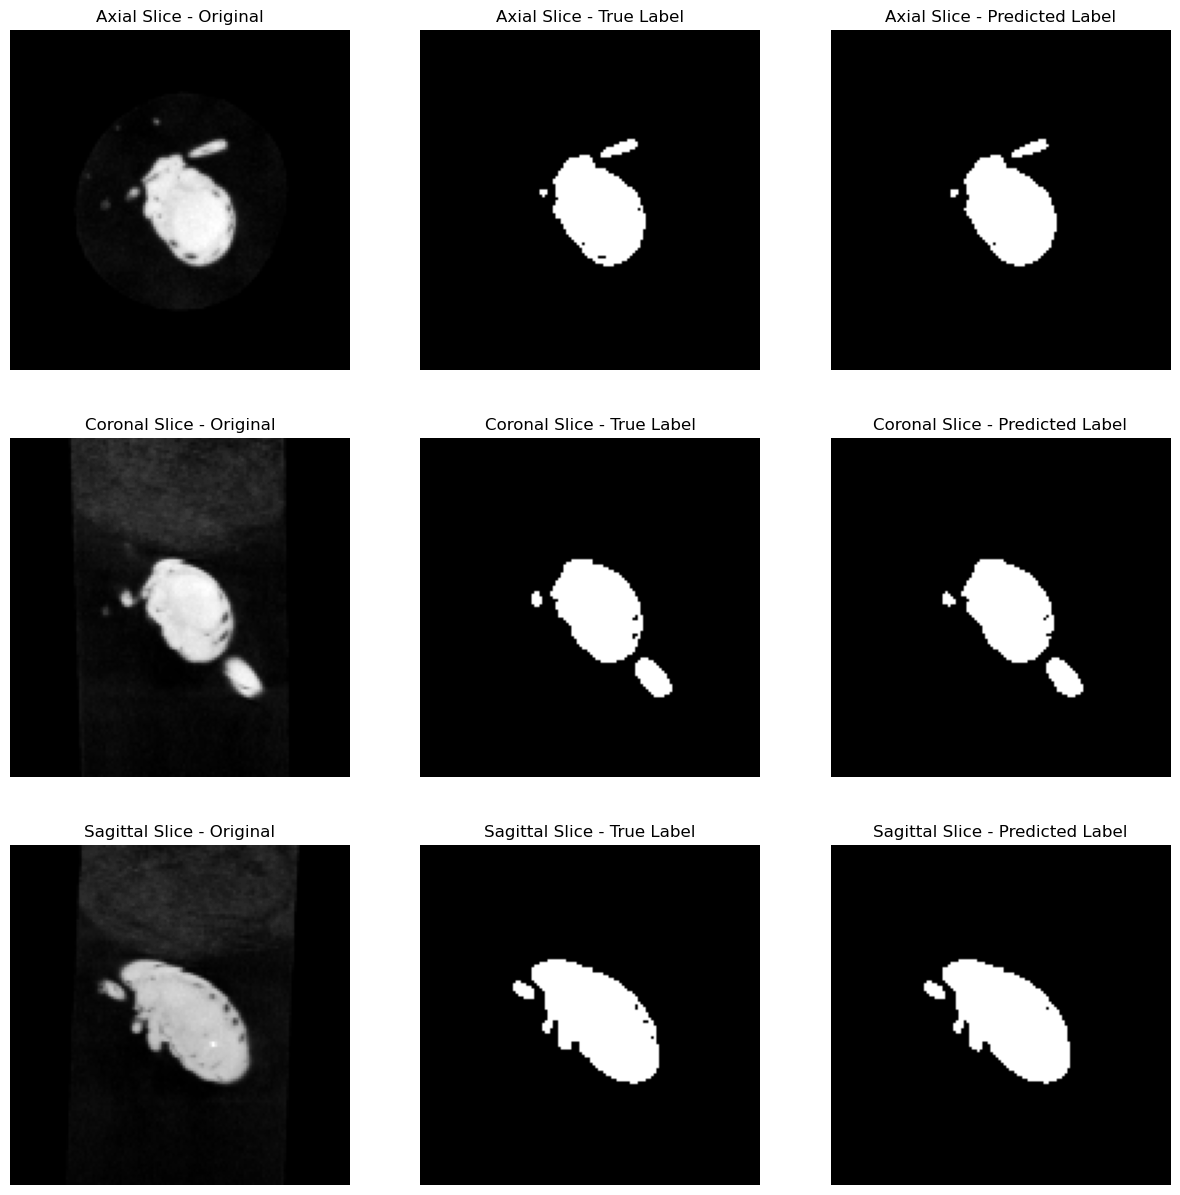

In [8]:
#------Visualize the predicted model------
# Convert predictions from probabilities and remove batch dimension
_, predicted_labels = torch.max(outputs, 1)
predicted_labels = predicted_labels.squeeze().cpu().numpy()

# Also, remove batch dimension from inputs and labels if present
inputs = inputs.squeeze().cpu().numpy()
true_labels = true_labels.squeeze().cpu().numpy()

# Selecting the middle slices for a good view, adjust indices as needed
axial_slice = predicted_labels.shape[0] // 2
coronal_slice = predicted_labels.shape[1] // 2
sagittal_slice = predicted_labels.shape[2] // 2

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
# Displaying original image slices
axes[0, 0].imshow(inputs[axial_slice], cmap='gray')
axes[0, 0].set_title('Axial Slice - Original')
axes[1, 0].imshow(inputs[:, coronal_slice, :], cmap='gray')
axes[1, 0].set_title('Coronal Slice - Original')
axes[2, 0].imshow(inputs[:, :, sagittal_slice], cmap='gray')
axes[2, 0].set_title('Sagittal Slice - Original')

# Displaying true label slices
axes[0, 1].imshow(true_labels[axial_slice], cmap='gray')
axes[0, 1].set_title('Axial Slice - True Label')
axes[1, 1].imshow(true_labels[:, coronal_slice, :], cmap='gray')
axes[1, 1].set_title('Coronal Slice - True Label')
axes[2, 1].imshow(true_labels[:, :, sagittal_slice], cmap='gray')
axes[2, 1].set_title('Sagittal Slice - True Label')

# Displaying predicted label slices
axes[0, 2].imshow(predicted_labels[axial_slice], cmap='gray')
axes[0, 2].set_title('Axial Slice - Predicted Label')
axes[1, 2].imshow(predicted_labels[:, coronal_slice, :], cmap='gray')
axes[1, 2].set_title('Coronal Slice - Predicted Label')
axes[2, 2].imshow(predicted_labels[:, :, sagittal_slice], cmap='gray')
axes[2, 2].set_title('Sagittal Slice - Predicted Label')

for ax in axes.flatten():
    ax.axis('off')


In [9]:
# Resize or crop the predicted labels to match the desired dimensions (64, 32, 32)
# For this example, let's use slicing to crop, adjust this based on how your data needs to fit the target size
# Make sure your original data dimensions allow this operation without error
#from skimage.transform import resize

#desired_shape = (256, 128, 128)
#cropped_predicted_labels = resize(predicted_labels, desired_shape, order=1, preserve_range=True, anti_aliasing=True)

# Convert binary mask to grayscale by multiplying by 255
# Assuming cropped_predicted_labels is a binary mask with values 0 or 1
grayscale_predicted_labels = (predicted_labels * 255).astype(np.uint8)

# Save the array as a TIFF file
file_path = 'predicted_labels_256.tif'
tiff.imwrite(file_path, grayscale_predicted_labels)
print("Saved predicted labels as grayscale TIFF at:", file_path)


Saved predicted labels as grayscale TIFF at: predicted_labels_256.tif
